In [ ]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


# **Importing Libraries**

In [ ]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [ ]:
!pip install -U accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# **Defining Dataset Paths**

In [ ]:
train_path = '/content/drive/MyDrive/cidata_half/train'
valid_path= '/content/drive/MyDrive/cidata_half/valid'
test_path= '/content/drive/MyDrive/cidata_half/test'

# **Dataset Preprocessing**

In [ ]:
# Importing necessary libraries
import keras
import numpy as np

def datafn(path, num_images):
    """
    Function to preprocess images from a directory for a neural network model.

    Parameters:
        path (str): Path to the directory containing images.
        num_images (int): Total number of images to process.

    Returns:
        tuple: A tuple containing preprocessed image data X and labels Y.
    """

    # Initializing an image generator object
    img_generator = keras.preprocessing.image.ImageDataGenerator()

    # Setting seed for reproducibility
    seed = 10

    # Generating batches of images from the directory
    images_set = img_generator.flow_from_directory(
        path,
        shuffle=False,
        batch_size=64,
        class_mode='binary',
        target_size=(256, 320)
    )

    # Calculating the number of batches
    num_batches = len(images_set)

    # Initializing lists to store processed images and labels
    X = []
    Y = []

    # Iterating through each batch
    for i in range(num_batches):
        # Retrieving the next batch
        batch = next(images_set)
        batch_images = batch[0]  # Extracting images from the batch
        batch_labels = batch[1]  # Extracting labels from the batch

        # Iterating through each image and label in the batch
        for ind, lb in enumerate(batch_labels):
            if lb == 0:  # If label is 0, add image to X
                X.append(batch_images[ind])
            else:  # If label is not 0, add mean of image channels to Y
                Y.append(np.mean(batch_images[ind], axis=2))

    # Converting lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Binarizing Y based on a threshold (100) and reshaping
    Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

    # Printing min and max values of Y
    print(Y.min())
    print(Y.max())

    return X, Y  # Returning preprocessed images and labels


In [ ]:
X_train,Y_train=datafn(train_path,1600)
X_val,Y_val=datafn(valid_path,300)
X_test,Y_test=datafn(test_path,300)

Found 1600 images belonging to 2 classes.
0
1
Found 300 images belonging to 2 classes.
0
1
Found 300 images belonging to 2 classes.
0
1


In [ ]:
len(X_train)

800

In [ ]:
import os

# Defining the path to the training directory
train_path = '/content/drive/MyDrive/cidata_half/train/labels'

# Counting the number of images in the training directory
num_train_images = len(os.listdir(train_path))

# Printing the number of images in the training directory
print("Number of images in train directory:", num_train_images)


Number of images in train directory: 800


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (800, 256, 320, 3)
Shape of X_val: (150, 256, 320, 3)
Shape of Y_train: (800, 256, 320, 1)
Shape of Y_val: (150, 256, 320, 1)
Shape of X_test: (150, 256, 320, 3)
Shape of Y_test: (150, 256, 320, 1)


In [ ]:
len(X_train)

800

# **Defing The Model And Its Parameters**

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model

def unet(input_size=(256, 320,3)):
    """
    Implementation of a U-Net architecture for semantic segmentation.

    Parameters:
        input_size (tuple): Size of the input images (height, width, channels).

    Returns:
        keras.models.Model: U-Net model.
    """

    # Input layer
    inputs = Input(input_size)

    # Rescaling layer to normalize input values
    rescale = keras.layers.Rescaling(1./255)(inputs)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Creating the U-Net model
model = unet()


In [ ]:

# Compiling the model with optimizer, loss function, and evaluation metrics
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])

# Printing the summary of the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 320, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 320, 64)         1792      ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 320, 64)         36928     ['conv2d[0][0]']              
                                                                                              

# **Training The Model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Define the path to the folder where you want to save TensorBoard logs
tensorboard_log_dir = '/kaggle/working/logs'

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

# train the model
epochs = 16
batch_size = 8

# Add TensorBoard callback to the list of callbacks
callbacks = [
    ModelCheckpoint("save_at_{epoch}.h5"),
    tensorboard_callback,
]


# Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/16
100/100 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.9582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 143s 1s/step - loss: 0.3822 - accuracy: 0.9582 - val_loss: 0.0372 - val_accuracy: 0.9661
Epoch 2/16
100/100 [==============================] - 89s 895ms/step - loss: 0.0332 - accuracy: 0.9675 - val_loss: 0.0348 - val_accuracy: 0.9661
Epoch 3/16
100/100 [==============================] - 90s 897ms/step - loss: 0.0305 - accuracy: 0.9675 - val_loss: 0.0325 - val_accuracy: 0.9661
Epoch 4/16
100/100 [==============================] - 90s 901ms/step - loss: 0.0285 - accuracy: 0.9675 - val_loss: 0.0294 - val_accuracy: 0.9661
Epoch 5/16
100/100 [==============================] - 91s 915ms/step - loss: 0.0274 - accuracy: 0.9676 - val_loss: 0.0289 - val_accuracy: 0.9661
Epoch 6/16
100/100 [==============================] - 90s 900ms/step - loss: 0.0268 - accuracy: 0.9682 - val_loss: 0.0295 - val_accuracy: 0.9668
Epoch 7/16
100/100 [==============================] - 90s 897ms/step - loss: 0.0249 - accuracy: 0.9702 - val_loss: 0.0265 - val_accuracy: 0.968

# **Saving The Model And Its Weights**

In [ ]:
# Save the trained model
model.save("unet_model.h5")


In [ ]:
# Save only the model weights
model.save_weights("weights_half_16.h5")


In [ ]:
model = unet()

# Load only the model weights
model.load_weights("/content/drive/MyDrive/weights_half_16.h5")

# **Predictions on Test Dataset**

In [ ]:

outputs = model.predict(X_test)

5/5 [==============================] - 44s 5s/step


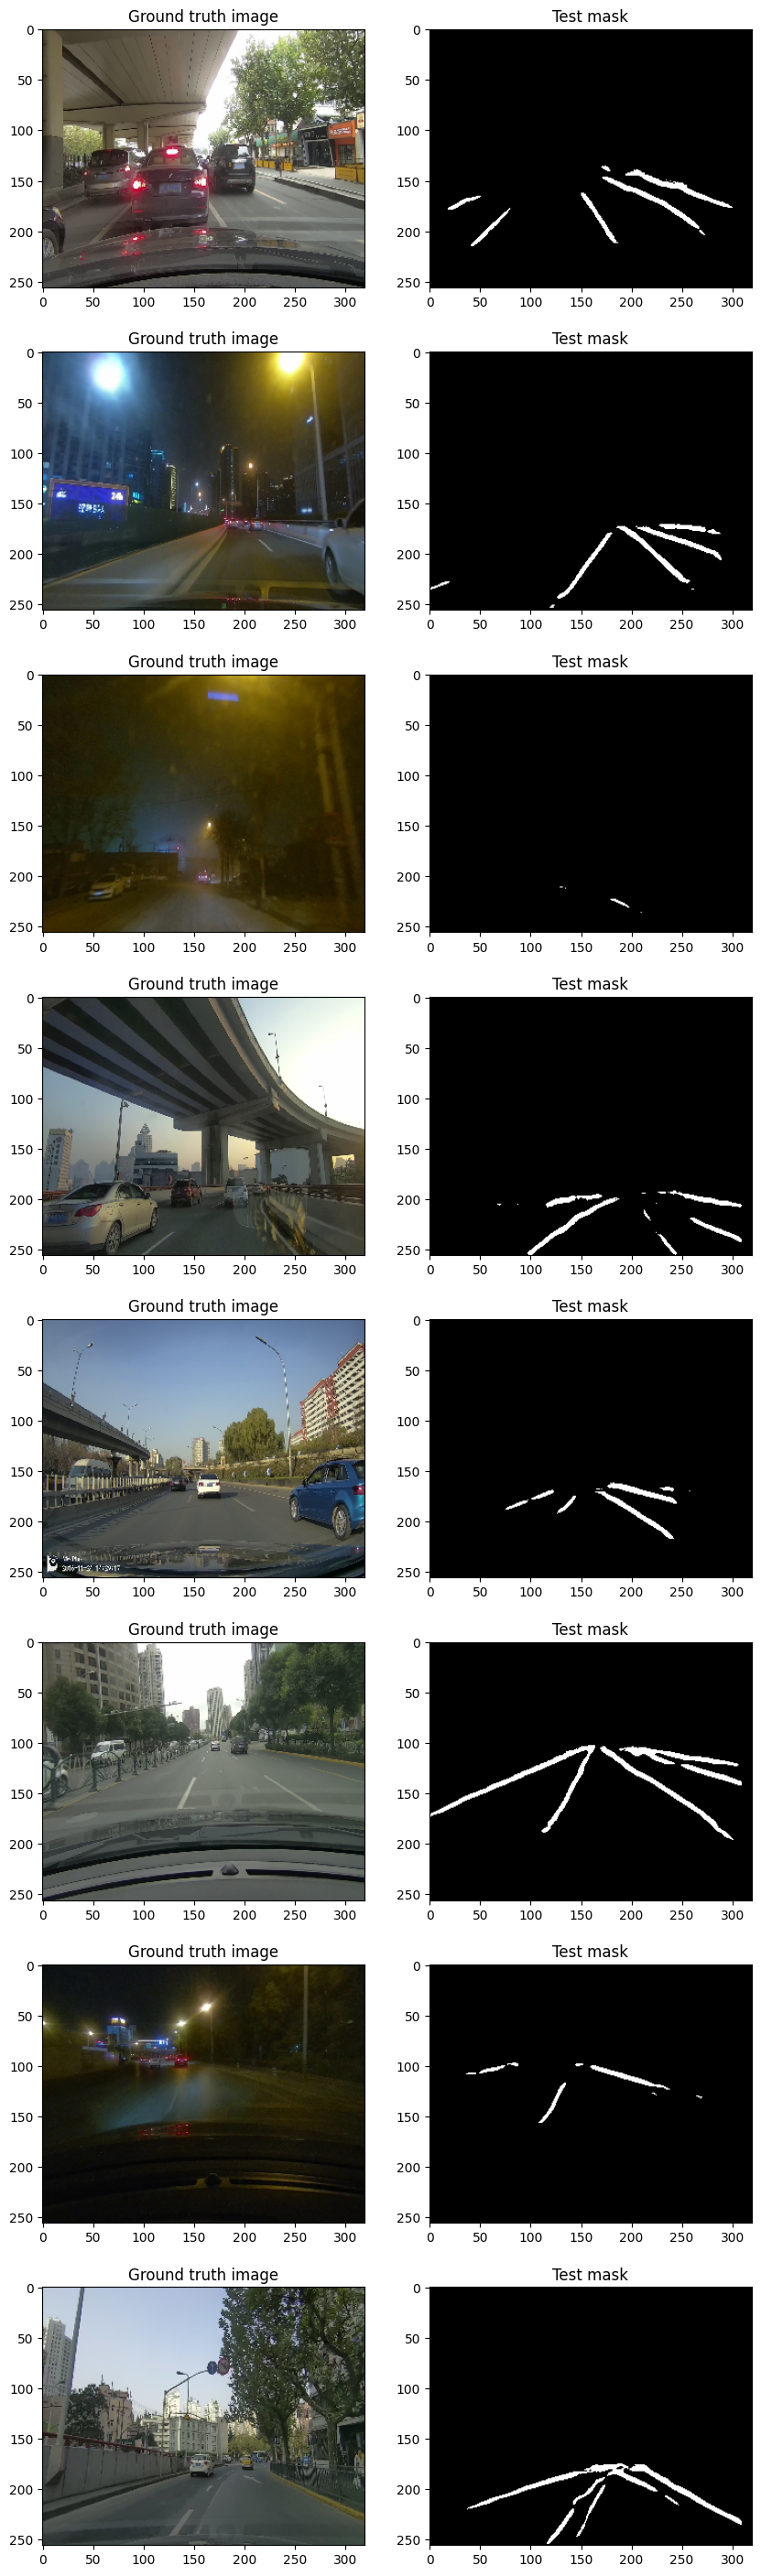

In [ ]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

outputs = (outputs >= .5).astype('int')
for i, j, k in zip(X_test[s:e], outputs[s:e], Y_test[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)

    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Test mask')
    index += 2

## **Save predicted test outputs**

In [ ]:
import os
from PIL import Image

# Define a function to save images
def save_images(outputs, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    for i, output in enumerate(outputs):
        # Convert the output to image format
        output_image = Image.fromarray((output[:, :, 0] * 255).astype(np.uint8))
        # Save the image
        output_image.save(f"{output_folder}/output_{i}.png")

# Assuming 'outputs' is the variable containing the model's predictions
# 'output_folder' is the folder where you want to save the images
output_folder = "/content/drive/MyDrive/output_images_half_more"
save_images(outputs, output_folder)


# **Test Dataset Metrics**

In [ ]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

from sklearn.metrics import mean_squared_error
import math
# Calculate MSE
mse_value_test = mean_squared_error(Y_test.flatten(), outputs.flatten())

# Calculate RMSE
rmse_value_test = math.sqrt(mse_value_test)
# accuracy
accuracy.update_state(Y_test, outputs)
accuracy_value_test = accuracy.result().numpy()
# precision
precision.update_state(Y_test, outputs)
precision_value_test = precision.result().numpy()
# recal
recal.update_state(Y_test, outputs)
recal_value_test = recal.result().numpy()
# f1 score
f1_score_test = 2 / ((1 / precision_value_test) + (1 / recal_value_test))

# Intersection over union (IoU)
iou.update_state(Y_test, outputs)
iou_value_test = iou.result().numpy()

print("Test Accuracy:", accuracy_value_test)
print("Precision:", precision_value_test)
print("Recall:", recal_value_test)
print('F1 Score: ', f1_score_test)
print('IoU: ', iou_value_test)
# Print the results
print("Mean Squared Error (MSE):", mse_value_test)
print("Root Mean Squared Error (RMSE):", rmse_value_test)

Test Accuracy: 0.9739788
Precision: 0.72143775
Recall: 0.41764092
F1 Score:  0.5290274253169952
IoU:  0.35964465
Mean Squared Error (MSE): 0.026021158854166667
Root Mean Squared Error (RMSE): 0.16131075244436333


# **Predictions on Validation Dataset**

In [ ]:
preds = model.predict(X_val)
preds.max(), preds.min()

5/5 [==============================] - 3s 661ms/step


(0.9327013, 0.0)

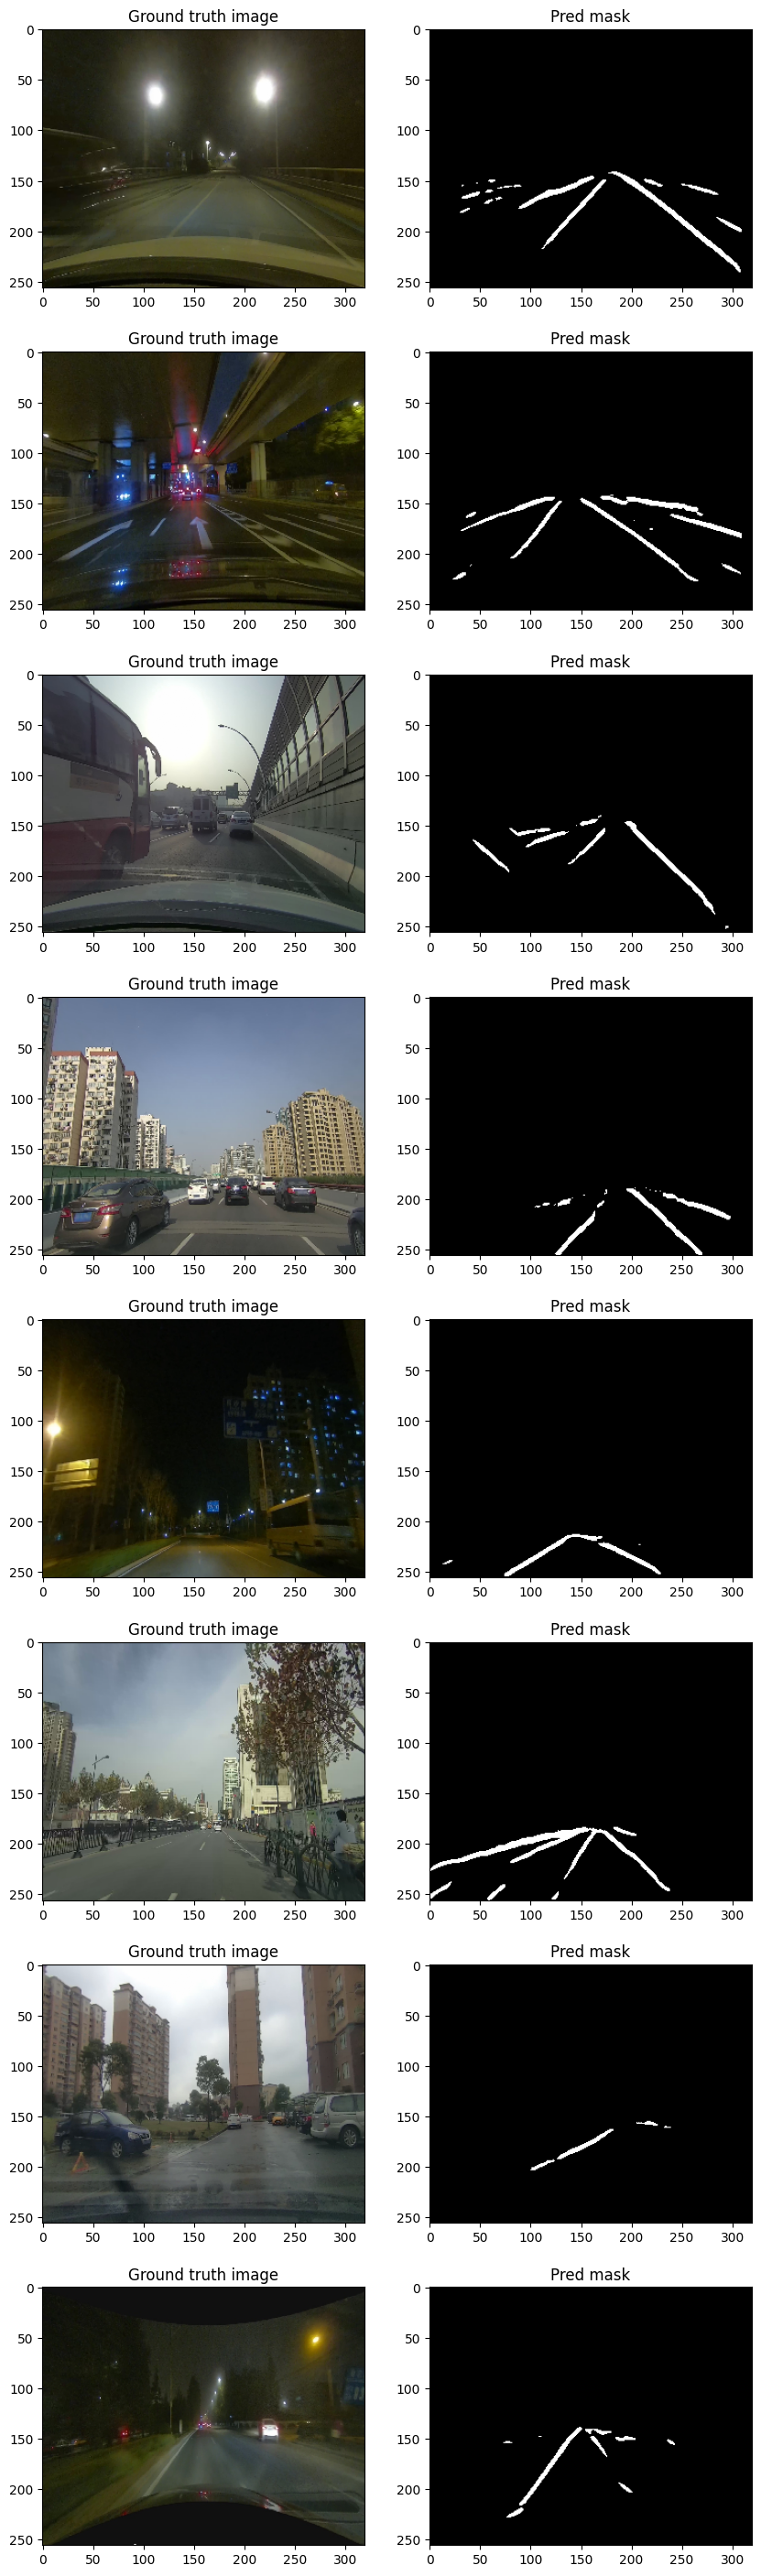

In [ ]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)

    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

# **Validation Dataset Metrics**

In [ ]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
from sklearn.metrics import mean_squared_error
import math
# Calculate MSE
mse_value_val = mean_squared_error(Y_val.flatten(), preds.flatten())

# Calculate RMSE
rmse_value_val = math.sqrt(mse_value_val)
# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value_val = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value_val = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value_val = recal.result().numpy()
# f1 score
f1_score_val = 2 / ((1 / precision_value_val) + (1 / recal_value_val))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value_val = iou.result().numpy()

print("Accuracy:", accuracy_value_val)
print("Precision:", precision_value_val)
print("Recall:", recal_value_val)
print('F1 Score: ', f1_score_val)
print('IoU: ', iou_value_val)
# Print the results
print("Mean Squared Error (MSE):", mse_value_val)
print("Root Mean Squared Error (RMSE):", rmse_value_val)

Accuracy: 0.9731338
Precision: 0.68216306
Recall: 0.38796872
F1 Score:  0.494626799601217
IoU:  0.3285742
Mean Squared Error (MSE): 0.0268662109375
Root Mean Squared Error (RMSE): 0.16390915452621918


# **Metrics Graphs**

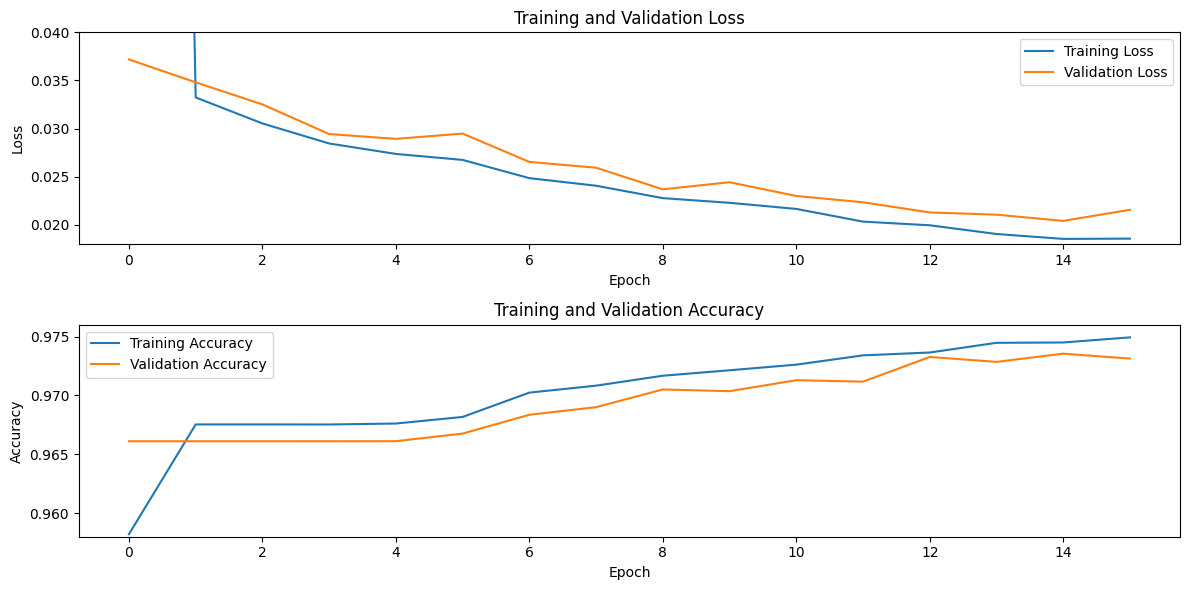

In [ ]:
# Plot training and validation metrics in a way that they converge at accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0180, 0.0400)  # Set y-axis limits for loss

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.9580, 0.9760)  # Set y-axis limits for accuracy

plt.tight_layout()  # Adjust layout for better visualization

plt.show()

## **Recall**

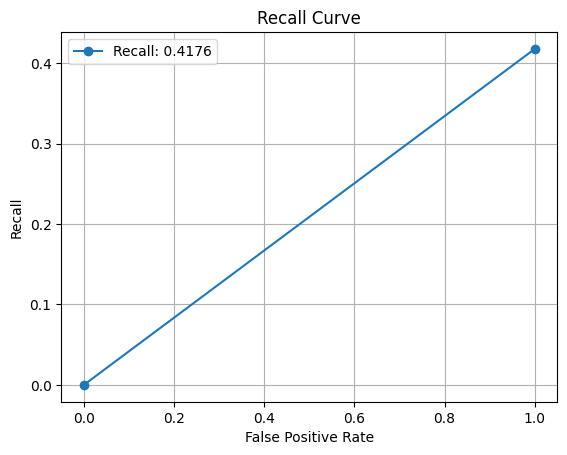

In [ ]:
from sklearn.metrics import recall_score

# Calculate recall
recall_val = recall_score(Y_test.flatten(), outputs.flatten())
# Plot Recall Curve
plt.plot([0, 1], [0, recall_val], label=f'Recall: {recall_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('recall_curve.png')
plt.show()

## **Precision**

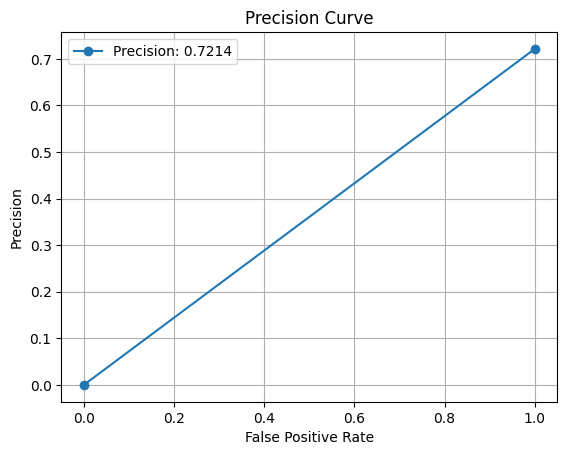

In [ ]:
from sklearn.metrics import precision_score

# Calculate precision
precision_val = precision_score(Y_test.flatten(), outputs.flatten())

# Plot Precision Curve
plt.plot([0, 1], [0, precision_val], label=f'Precision: {precision_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.grid(True)
plt.savefig('precision_curve.png')
plt.show()

## **Precision-Recall-Curve**

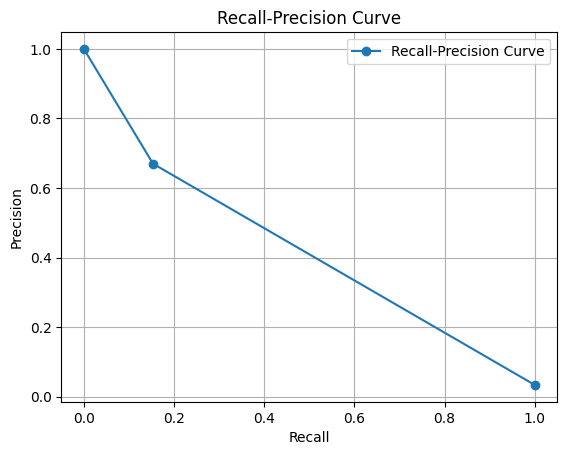

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(Y_val.flatten(), preds.flatten())

# Plot Recall-Precision Curve
plt.plot(recall, precision, label='Recall-Precision Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend()
plt.grid(True)
plt.savefig('recall_precision_curve.png')
plt.show()

## **F1-Score**

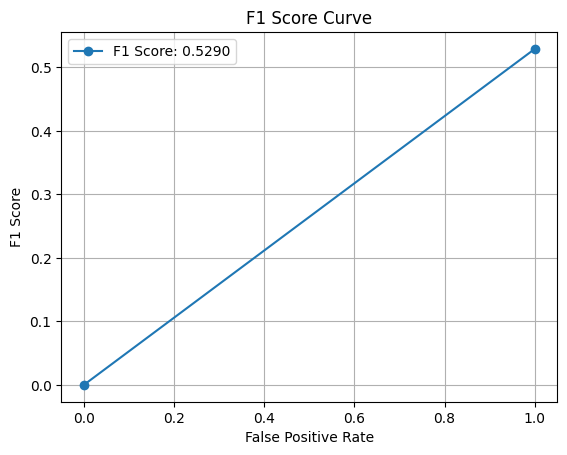

In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 Score
f1_score_val = f1_score(Y_test.flatten(), outputs.flatten())

# Plot F1 Score Curve
plt.plot([0, 1], [0, f1_score_val], label=f'F1 Score: {f1_score_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_curve.png')
plt.show()

## **Accuracy**

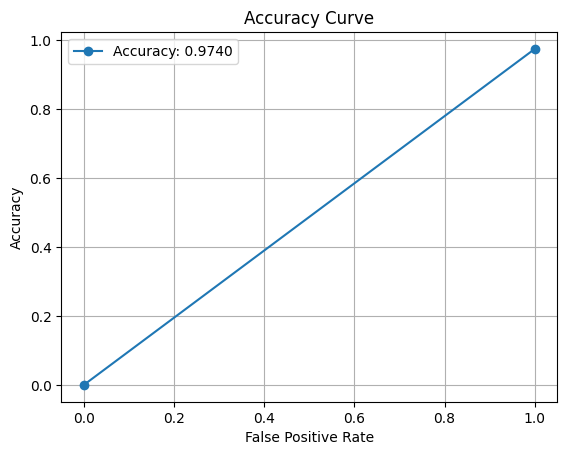

In [ ]:
# Plot Accuracy Curve
plt.plot([0, 1], [0, accuracy_value_test], label=f'Accuracy: {accuracy_value_test:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png')
plt.show()

## **Confusion Matrix**

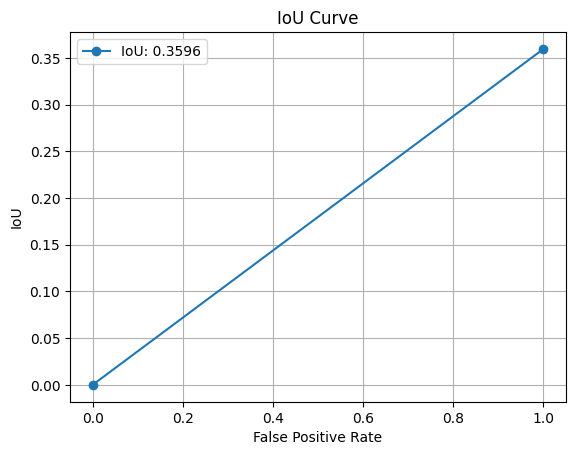

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test.flatten(), outputs.flatten())

# Calculate True Positive, False Positive, False Negative
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

# Calculate IoU (Jaccard Index)
iou_val = tp / (tp + fp + fn)

# Plot IoU Curve
plt.plot([0, 1], [0, iou_val], label=f'IoU: {iou_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('IoU')
plt.title('IoU Curve')
plt.legend()
plt.grid(True)
plt.savefig('iou_curve.png')
plt.show()

## **Recall-Precision Curve**

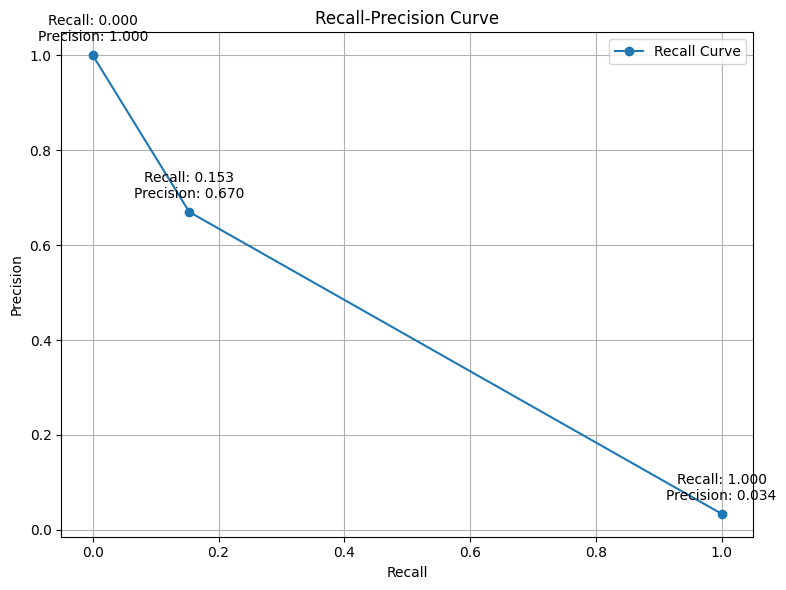

In [ ]:
# Plot Recall Curve with values
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Recall Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend()

# Annotate Recall and Precision values on the plot
for i, txt in enumerate(recall):
    plt.annotate(f'Recall: {recall[i]:.3f}\nPrecision: {precision[i]:.3f}', (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Show the Recall Curve plot
plt.grid(True)
plt.tight_layout()
plt.show()